In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  CWD = '/content/drive/MyDrive/DataSources/SkinCare'
  os.chdir(CWD)
except:None
G_path = './Project_Data'

In [2]:
import pandas as pd
import os
import seaborn as sns
from sklearn import *
import sklearn as sk
from sklearn import *
import numpy as np
from scipy.stats import chi2_contingency
import features
from features.usefull_functions import *
from features.NETs import *
from features.Model_Training import *
import datetime as dt
import pickle as pickle
import torch
import json
import random
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from statistics import mean
import warnings
warnings.filterwarnings('ignore')
device = None
try:
    c = torch.cuda.is_available()
    if c:
        print('devis: cuda')
        device = 'cuda'
    else:
        try :
            m = torch.backends.mps.is_available()
            if m:
                device = 'mps'
                print('devis: mps')  
        except:    
            device = 'cpu'
            print('devis: cpu')           
except:
    None

devis: mps


# **Import Data for Classifiers**

In [4]:
image_label = 'image_label'  #[image_label, binary_label]
select_features = False

# 280x210
file = 'CNN_280x210_Ouput_MultiClass'
data = pd.read_pickle(G_path + '/07_CNNs_Output_DataSet/' + file)

blc_test_list = pickle.load(open(G_path + '/02_Augmented_MetaData/balanced_test_set','rb'))
# Evaluation_set = pickle.load(open(G_path + '/DataSet_280x210/' + file,'rb'))


cols_remove = ['image_id','image_label','dx','lesion_id','type','binary_label','label_description']

selected_feature = ['CNN_0','CNN_1','CNN_2','CNN_3','CNN_4','CNN_5','CNN_6','age','dx_type_consensus','dx_type_follow_up','dx_type_histo']




train_data = data[data.type=='train']
valid_data = data[data.type=='valid']
test_data = data[data.type=='test']
blc_test_data = data.merge(blc_test_list['image_id'], how='inner',on='image_id')


train_label = train_data[image_label]
train_data = train_data.drop(columns= cols_remove)
valid_label = valid_data[image_label]
valid_data = valid_data.drop(columns=cols_remove)
test_label = test_data[image_label]
test_data = test_data.drop(columns=cols_remove)
blc_label = blc_test_data[image_label]
blc_data = blc_test_data.drop(columns=cols_remove)

if select_features:
    train_data = train_data[selected_feature]
    valid_data = valid_data[selected_feature]
    test_data = test_data[selected_feature]
    blc_data = blc_test_data[selected_feature]


train_data_arrays = np.stack(train_data.values)  
train_label_arrays = np.stack(train_label.values)
train_label_arrays_One = pd.get_dummies(train_label_arrays).values  

valid_data_arrays = np.stack(valid_data.values)  
valid_label_arrays = np.stack(valid_label.values)  
valid_label_arrays_One = pd.get_dummies(valid_label_arrays).values  

test_data_arrays = np.stack(test_data.values)  
test_label_arrays = np.stack(test_label.values)  
test_label_arrays_One = pd.get_dummies(test_label_arrays).values  

blc_data_arrays = np.stack(blc_data.values)  
blc_label_arrays = np.stack(blc_label.values)  
blc_label_arrays_One = pd.get_dummies(blc_label_arrays).values 

#Numpy Arrays
input_data_Array = (train_data_arrays , valid_data_arrays, test_data_arrays , np.concatenate((train_data_arrays,valid_data_arrays )))
labels_Array = (train_label_arrays,valid_label_arrays,test_label_arrays, np.concatenate((train_label_arrays,valid_label_arrays)))
labels_One_Array = (train_label_arrays_One,valid_label_arrays_One,test_label_arrays_One, np.concatenate((train_label_arrays_One,valid_label_arrays_One)))

# Tensors
def to_Torch(x):
    return torch.tensor(x,dtype= torch.float32)

input_data_Tensor = (to_Torch(train_data_arrays),to_Torch(valid_data_arrays)  , to_Torch(test_data_arrays) , to_Torch(np.concatenate((train_data_arrays,valid_data_arrays))))
labels_Tensor = (to_Torch(train_label_arrays),to_Torch(valid_label_arrays),to_Torch(test_label_arrays) , to_Torch(np.concatenate((train_label_arrays,valid_label_arrays))) )
labels_OneHot_Tensor = (to_Torch(train_label_arrays_One),to_Torch(valid_label_arrays_One),to_Torch(test_label_arrays_One), to_Torch(np.concatenate((train_label_arrays_One,valid_label_arrays_One))))

blc_data_Tensor = (to_Torch(blc_data_arrays))

# **Import CNN DataSets**

In [5]:
file = 'Input_DataSet_280x210' 
input_data , labels = pickle.load(open(G_path + '/06_Rescaled_DataSet/'+ file,'rb'))
labels_biary = labels[1]
labels_multi = labels[0]

file = 'Input_DataSet_A_E' 
A_E_input_data , A_E_labels = pickle.load(open(G_path + '/05_AutoEncoded_DataSet/'+ file,'rb'))
A_E_labels_biary = A_E_labels[1]
A_E_labels_multi = A_E_labels[0]

file = 'Balanced_Test_Set_280x210' 
BLC_test_280x210 = pickle.load(open(G_path + '/06_Rescaled_DataSet/' + file,'rb'))

file = 'Balanced_Test_Set_A_E' 
BLC_test_A_E = pickle.load(open(G_path + '/05_AutoEncoded_DataSet/' + file,'rb'))

Meta_Data_Augmented = pickle.load(open( G_path + '/02_Augmented_MetaData/Meta_Data_Augmented','rb'))

# **CNN Networks: Configuration**

In [6]:
net_list = [func for func in dir(CNN_Nets) if callable(getattr(CNN_Nets, func)) and not func.startswith("__")]
X_ = input_data[0][0:5]
for net in net_list:
    print(net)
    model_ = getattr(CNN_Nets,net)
    fc_features = model_().dimention_set(X_)
    model_ = getattr(CNN_Nets,net)
    model_.fc_features = fc_features
    out = model_().forward(X_)
    setattr(CNN_Nets,net,model_)
    # print(out.shape)

Net1
Net10
Net11
Net2
Net3
Net4
Net5
Net6
Net7
Net8
Net8_a
Net8_a_binary
Net8_b
Net8_b_binary
Net9


# **Classifiers Performance Evaluation**

In [7]:
RF_Model = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Trained_Saved_Models/' + 'RF_Model' , 'rb'))
SVM_Model = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Trained_Saved_Models/' + 'SVM_Model' , 'rb'))
GB_Model = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Trained_Saved_Models/' + 'GB_Model' , 'rb'))
MLP_Model = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Trained_Saved_Models/' + 'MLP_Model' , 'rb'))
KNN_Model = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Trained_Saved_Models/' + 'KNN_Model' , 'rb'))
Biased_Model = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Trained_Saved_Models/' + 'Biased_Model' , 'rb'))

In [8]:
RF_Model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=False, max_depth=20, max_features='auto',
                       n_jobs=-1, random_state=0)>

Nr. of Data : 
 407
Accuracy of The Model : 
 0.7223587223587223


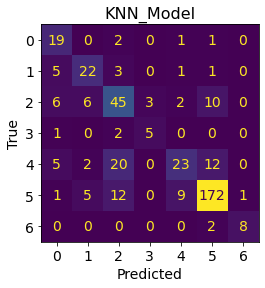

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,51.4%,82.6%,95.3%,63.3%
1,7.9%,62.9%,68.8%,96.5%,65.7%
2,17.7%,53.6%,62.5%,88.4%,57.7%
3,2.0%,62.5%,62.5%,99.2%,62.5%
4,15.2%,63.9%,37.1%,96.2%,46.9%
5,49.1%,86.9%,86.0%,87.4%,86.4%
6,2.5%,88.9%,80.0%,99.7%,84.2%
Simple Avg.,nan%,67.1%,68.5%,94.7%,66.7%
Weighted Avg.,nan%,73.2%,72.2%,90.6%,71.9%


In [44]:
# Model 280x210
Balanced_Test_set = False 
Multi_to_binary = False

model = RF_Model  # {RF_Model,SVM_Model,GB_Model,MLP_Model,KNN_Model,Biased_Model}

if Balanced_Test_set:
    X = blc_data_arrays
    Y = blc_label_arrays
else:
    X = input_data_Array[2]
    Y = labels_Array[2]

Y_pred = model.predict(X)
if Multi_to_binary:
    Y_binary =  label_to_binary(Y)
    Y_pred_binary =  label_to_binary(Y_pred)
    results = model_evaluation(Y_binary,Y_pred_binary,'KNN_Model')
else:
    results = model_evaluation(Y,Y_pred,'KNN_Model')
results

# **Ensemble Models**

In [27]:
class_models , best_overall_model

(  class_  model
 0      0      0
 1      1      2
 2      2      3
 3      3      0
 4      4      2
 5      5      0
 6      6      1,
 0)

In [33]:
class_models[class_models.model==0]['class_'].to_list()

[0, 3, 5]

In [46]:
X = input_data_Array[2]
Y = labels_Array[2]
X = blc_data_arrays
Y = blc_label_arrays
classes = np.unique(Y).tolist()
Ensemble_details = pd.DataFrame()
models = [RF_Model,SVM_Model,GB_Model,KNN_Model]
for i in range(0, len(models)):
    Y_pred = models[i].predict(X)
    details_ =  recall_specificity(Y, Y_pred)
    details_.reset_index(inplace=True)
    # details_.rename(columns={'index':'class'},inplace=True)
    details_['class_'] = details_['index']
    details_['model'] = i
    Ensemble_details = pd.concat([Ensemble_details,details_],axis=0)
Ensemble_details = Ensemble_details.sort_values(['class_','f1_score'],ascending=[True,False]).groupby('class_').head(1).reset_index()
print(Ensemble_details)
best_overall_model = Ensemble_details[Ensemble_details.class_=='Weighted Avg.']['model'].iloc[0]
Ensemble_details = Ensemble_details[~Ensemble_details['class_'].str.contains('Avg.',na=False)]
class_models = Ensemble_details[['class_','model']]
best_models = list(set(class_models.model))

Y_pred = []
for j in range(X.shape[0]):
    X_ = X[j:j+1]
    Y_pred__ = None
    print('Real label: ', Y[j])
    for i in range(0, len(models)):
        if i in best_models:
            Y_pred_ = models[i].predict(X_)[0]
            print('Y_pred_: ',Y_pred_)
            print(f'Model_{i}_best_class: {class_models[class_models.model==i].class_.to_list()}')
            if Y_pred_ in class_models[class_models.model==i]['class_'].to_list():
                Y_pred__ = Y_pred_
                
                break
    if Y_pred__ == None:
        # print('Y_pred__: ',Y_pred__)
        print('koo')
        Y_pred_ = models[best_overall_model].predict(X_)[0]
        Y_pred.append(Y_pred_)
        print('...=> ', Y_pred_)
    else:
        Y_pred.append(Y_pred__)
        print('ok')




   level_0          index     0     1    2    3    4     5     6   weights  \
0        0              0  11.0   1.0  1.0  0.0  2.0   0.0   0.0  0.142857   
1        1              1   1.0  11.0  1.0  0.0  1.0   1.0   0.0  0.142857   
2        2              2   0.0   0.0  8.0  0.0  4.0   3.0   0.0  0.142857   
3        3              3   1.0   1.0  3.0  8.0  0.0   2.0   0.0  0.142857   
4        4              4   0.0   1.0  4.0  0.0  8.0   2.0   0.0  0.142857   
5        5              5   0.0   1.0  2.0  0.0  0.0  12.0   0.0  0.142857   
6        6              6   0.0   0.0  0.0  0.0  0.0   1.0  14.0  0.142857   
7        7    Simple Avg.   NaN   NaN  NaN  NaN  NaN   NaN   NaN       NaN   
8        8  Weighted Avg.   NaN   NaN  NaN  NaN  NaN   NaN   NaN       NaN   

   Precision  Recall_Sensitivity  Specificity  f1_score         class_  model  
0   0.846154            0.733333     0.977778  0.785714              0      0  
1   0.785714            0.733333     0.966667  0.758621    

In [42]:
Y_pred[:5], Y[:5]

([4, 5, 5, 5, 5], array([4, 5, 5, 5, 5], dtype=int8))

Nr. of Data : 
 105
Accuracy of The Model : 
 0.6857142857142857


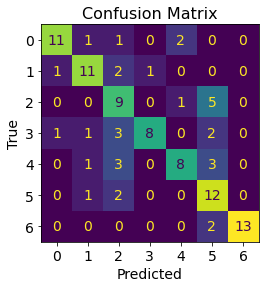

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,14.3%,84.6%,73.3%,97.8%,78.6%
1,14.3%,73.3%,73.3%,95.6%,73.3%
2,14.3%,45.0%,60.0%,87.8%,51.4%
3,14.3%,88.9%,53.3%,98.9%,66.7%
4,14.3%,72.7%,53.3%,96.7%,61.5%
5,14.3%,50.0%,80.0%,86.7%,61.5%
6,14.3%,100.0%,86.7%,100.0%,92.9%
Simple Avg.,nan%,73.5%,68.6%,94.8%,69.4%
Weighted Avg.,nan%,73.5%,68.6%,94.8%,69.4%


In [49]:
model_evaluation(Y, Y_pred)

Nr. of Data : 
 105
Accuracy of The Model : 
 0.8666666666666667


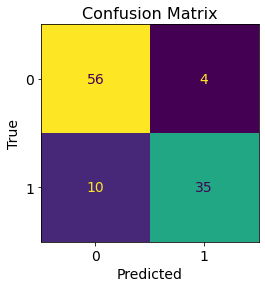

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,57.1%,84.8%,93.3%,77.8%,88.9%
1,42.9%,89.7%,77.8%,93.3%,83.3%
Simple Avg.,nan%,87.3%,85.6%,85.6%,86.1%
Weighted Avg.,nan%,86.9%,86.7%,84.4%,86.5%


In [50]:
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
model_evaluation(Y_binary,Y_pred_binary)

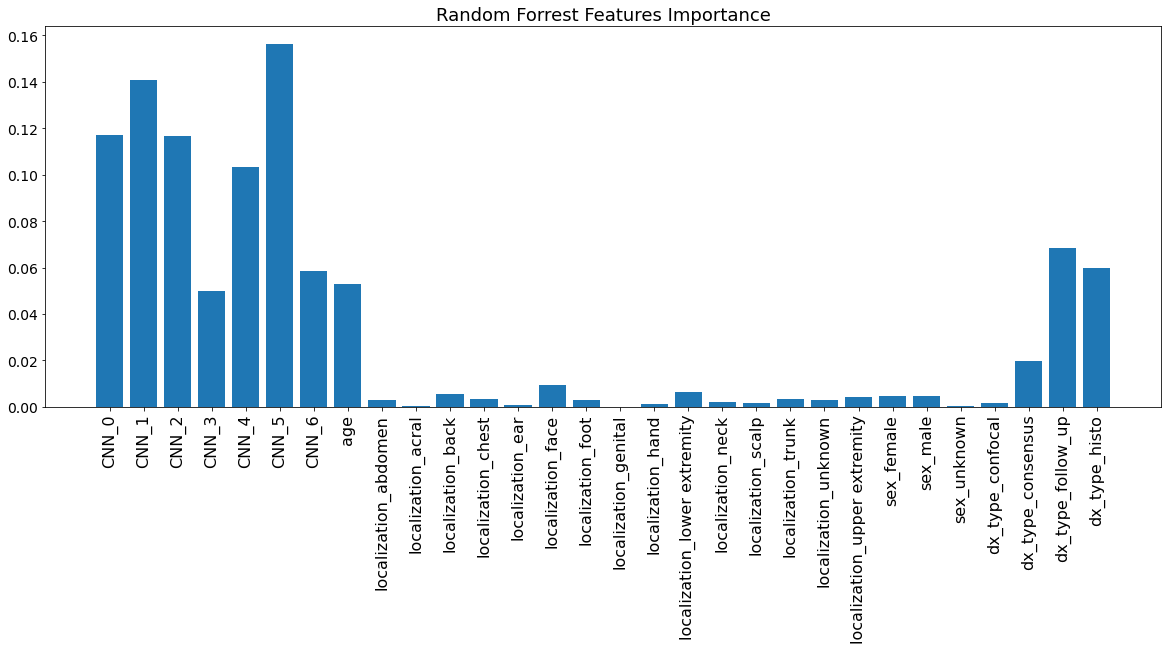

In [9]:
importance = RF_Model.feature_importances_

features_name = list(train_data.columns)
plt.subplots(figsize=(20,7))
plt.bar(features_name, importance)
plt.xticks(fontsize=16, rotation=90)
plt.title('Random Forrest Features Importance',fontsize = 18)
plt.show()

In [10]:
C_280 = 'CNN_280x210_MultiClassModel0_24_Jun22_22-38' # Best of grid search ['CNN_280x210_Model5_23_Jun22_12-55','CNN_280x210_Model4_22_Jun22_00-14]
C_280_binary = 'CNN_280x210_Binary_24_Jun22_22-17'

CNN_280x210_multi = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/'+ C_280 , 'rb') ).eval()
CNN_280x210_binary = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/'+ C_280_binary , 'rb') ).eval()

A_E = 'A_E_CNN_Model6_22_Jun22_00-29' #Best of grid search
A_E_binary = 'A_E_CNN_Model0_25_Jun22_09-35'

# [CNN_Nets.Net8_a, Model_Training_with_loader] = pickle.load(open(G_Models+'/Net8_Model_Trainin','rb'))
CNN_A_En_multiclass = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/' + A_E , 'rb') ).eval()
CNNA_En_binary = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/' + A_E_binary , 'rb') ).eval()

# **CNN Models Performance Evaluation**

Nr. of Data : 
 407
Accuracy of The Model : 
 0.6535626535626535


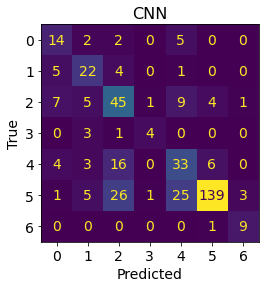

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,45.2%,60.9%,95.6%,51.9%
1,7.9%,55.0%,68.8%,95.2%,61.1%
2,17.7%,47.9%,62.5%,85.4%,54.2%
3,2.0%,66.7%,50.0%,99.5%,57.1%
4,15.2%,45.2%,53.2%,88.4%,48.9%
5,49.1%,92.7%,69.5%,94.7%,79.4%
6,2.5%,69.2%,90.0%,99.0%,78.3%
Simple Avg.,nan%,60.3%,65.0%,94.0%,61.6%
Weighted Avg.,nan%,70.8%,65.4%,92.4%,66.9%


In [11]:
# Model 280x210
Evaluation_set = 'test'  #{train, valid, test, balanced_test}
Multi_to_binary = False
model = CNN_280x210_multi  # {CNN_280x210_multi, CNN_A_En_multiclass}

if Evaluation_set == 'train': i = 0
elif Evaluation_set == 'valid': i=1
elif Evaluation_set == 'test': i=2

if Evaluation_set == 'balanced_test':
    if model in [CNN_280x210_multi, CNN_280x210_binary]:
        X = BLC_test_280x210[0]
        Y = BLC_test_280x210[1]
    else:
        X = BLC_test_A_E[0]
        Y = BLC_test_A_E[1]       
else:
    if Evaluation_set == 'train': i = 0
    elif Evaluation_set == 'valid': i=1
    elif Evaluation_set == 'test': i=2
    if model in [CNN_280x210_multi, CNN_280x210_binary]:
        X = input_data[i]
        Y = labels_multi[i]
    else:
        X = A_E_input_data[i]
        Y = A_E_labels_multi[i]  

n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
Y_pred_prob = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n].detach()
    Y_prob = torch.softmax(model.forward_noDrop(X_),dim=1).detach()
    Y_ = model.forward_noDrop(X_).argmax(dim=1).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
    Y_pred_prob = torch.cat([Y_pred_prob,Y_prob]).detach()

if Multi_to_binary:
    Y_binary =  label_to_binary(Y)
    Y_pred_binary =  label_to_binary(Y_pred)
    results = model_evaluation(Y_binary,Y_pred_binary)
else:
    results = model_evaluation(Y,Y_pred,'CNN')
results

In [17]:
Y_OneH = sk.preprocessing.label_binarize(Y,classes=np.unique(Y))
sk.metrics.roc_auc_score(Y_OneH, Y_pred_prob,average='micro'),sk.metrics.roc_auc_score(Y_OneH, Y_pred_prob,average='macro') , sk.metrics.roc_auc_score(Y_OneH, Y_pred_prob,average='weighted')

(0.9332564639689946, 0.9105473886653532, 0.8893628555153951)

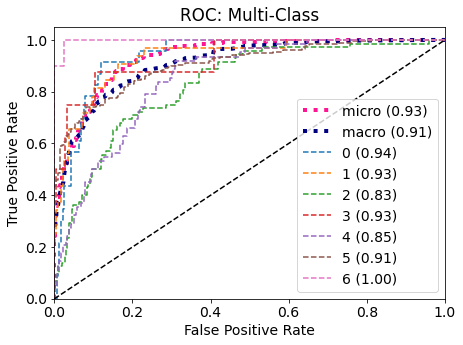

In [12]:
fpr, tpr, roc_auc = fpr_tpr_score(Y_OneH,Y_pred_prob)
plot_roc_auc_multi(fpr, tpr, roc_auc)

In [19]:
def recall_specificity(Y,Y_pred):
    CM = sk.metrics.confusion_matrix(Y,Y_pred)
    FP = CM.sum(axis=0) - np.diag(CM) 
    FN = CM.sum(axis=1) - np.diag(CM)
    TP = np.diag(CM)
    TN = CM.sum() - (FP + FN + TP)
    weights = CM.sum(axis=1) / CM.sum() 
    ACC = np.nan_to_num((TP+TN)/(TP+FP+FN+TN) , nan=0)
    Recall_Sensitivity = np.nan_to_num(TP/(TP+FN) , nan=0)
    Specificity = np.nan_to_num(TN/(TN+FP) , nan=0)
    Precision = np.nan_to_num(TP/(TP+FP) , nan=0)
    f1_score = np.nan_to_num( 2*Precision*Recall_Sensitivity / (Recall_Sensitivity + Precision), nan=0)
    Performance_DF = pd.concat([pd.DataFrame(CM),pd.DataFrame(weights, columns=['weights']),pd.DataFrame(Precision, columns=['Precision']),pd.DataFrame(Recall_Sensitivity,columns=['Recall_Sensitivity'])
        ,pd.DataFrame(Specificity, columns=['Specificity']),pd.DataFrame(f1_score, columns=['f1_score'])], axis=1)
    total_row1 = pd.Series({'Precision':mean(Precision),'Recall_Sensitivity':mean(Recall_Sensitivity),'Specificity':mean(Specificity),'f1_score':mean(f1_score)}, name='Simple Avg.')
    total_row2 = pd.Series({'Precision':sum(weights*Precision),'Recall_Sensitivity':sum(weights*Recall_Sensitivity),'Specificity':sum(weights*Specificity),'f1_score':sum(weights*f1_score)}, name='Weighted Avg.')
    Performance_DF = Performance_DF.append([total_row1,total_row2])
    cols = ['weights','Precision','Recall_Sensitivity','Specificity','f1_score']
    return Performance_DF

In [31]:
per_ = recall_specificity(Y,Y_pred).loc['Weighted Avg.']
test_accuracy , test_specificity = per_['Recall_Sensitivity'] , per_['Specificity']


In [33]:
test_accuracy 

0.6265356265356266

In [25]:
recall_specificity(Y,Y_pred)

,0,1,2,3,4,5,6,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,10.0,2.0,2.0,0.0,9.0,0.0,0.0,0.056511,0.357143,0.434783,0.953125,0.392157
1,6.0,19.0,4.0,0.0,2.0,1.0,0.0,0.078624,0.542857,0.593750,0.957333,0.567164
2,7.0,5.0,41.0,1.0,12.0,5.0,1.0,0.176904,0.471264,0.569444,0.862687,0.515723
3,0.0,2.0,1.0,4.0,1.0,0.0,0.0,0.019656,0.666667,0.500000,0.994987,0.571429
4,4.0,3.0,15.0,0.0,34.0,6.0,0.0,0.152334,0.390805,0.548387,0.846377,0.456376
5,1.0,4.0,24.0,1.0,29.0,138.0,3.0,0.491400,0.913907,0.690000,0.937198,0.786325
6,0.0,0.0,0.0,0.0,0.0,1.0,9.0,0.024570,0.692308,0.900000,0.989924,0.782609
Simple Avg.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.576422,0.605195,0.934519,0.581683
Weighted Avg.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.684974,0.626536,0.915096,0.644370
